In [1]:
import tensorflow as tf
import numpy as np
from keras import layers, models, optimizers, datasets, regularizers
import tensorflow_datasets as tfds
try:
  from extra_keras_datasets import svhn
except ModuleNotFoundError:
  !pip install extra_keras_datasets
  from extra_keras_datasets import svhn

from tensorflow.keras.utils import to_categorical

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
(train_normal, train_normal_labels), (test_normal, test_normal_labels) = svhn.load_data(type='normal')

In [3]:
(train_easy, train_easy_labels), (test_easy, test_easy_labels) = svhn.load_data(type='extra')

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Select 400 samples per class from the normal dataset
train_normal_all = []
train_normal_labels_all = []
for i in range(1, 11):
    idx = np.where(train_normal_labels == i)[0][:400]
    train_normal_all.append(train_normal[idx])
    train_normal_labels_all.append(train_normal_labels[idx])
train_normal_all = np.concatenate(train_normal_all, axis=0)
train_normal_labels_all = np.concatenate(train_normal_labels_all, axis=0)

# Select 200 samples per class from the easy dataset
train_easy_all = []
train_easy_labels_all = []
for i in range(1, 11):
    idx = np.where(train_easy_labels == i)[0][:200]
    train_easy_all.append(train_easy[idx])
    train_easy_labels_all.append(train_easy_labels[idx])
train_easy_all = np.concatenate(train_easy_all, axis=0)
train_easy_labels_all = np.concatenate(train_easy_labels_all, axis=0)

# Combine the selected samples and labels
train_all = np.concatenate([train_normal_all, train_easy_all], axis=0)
train_all_labels = np.concatenate([train_normal_labels_all, train_easy_labels_all], axis=0)

# Convert labels to categorical
train_all_labels_categorical = to_categorical(train_all_labels - 1, num_classes=10)


In [5]:
shuffle_idx = np.random.permutation(len(train_all))
train_all = train_all[shuffle_idx]
train_all_labels_categorical = train_all_labels_categorical[shuffle_idx]

In [6]:
train_all_mean = np.mean(train_all, axis=(0, 1, 2))
train_all_std = np.std(train_all, axis=(0, 1, 2))

train_all_norm = (train_all - train_all_mean) / train_all_std

In [7]:
test_mean = np.mean(test_normal, axis=(0, 1, 2))
test_std = np.std(test_normal, axis=(0, 1, 2))

test_norm = (test_normal - test_mean) / test_std

In [8]:
test_labels_categorical = to_categorical(test_normal_labels - 1, num_classes=10)

In [45]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),

    tf.keras.layers.Dropout(0.1),

    # Convolutional layers
    tf.keras.layers.Conv2D(96, (5, 5), strides=(1, 1),
                           padding='same', activation='relu',
                           input_shape=(32, 32, 3),
                           kernel_constraint=tf.keras.constraints.max_norm(4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),padding='same'),

    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1),
                           padding='same', activation='relu',
                           kernel_constraint=tf.keras.constraints.max_norm(4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1),
                           padding='same', activation='relu',
                           kernel_constraint=tf.keras.constraints.max_norm(4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

    tf.keras.layers.Dropout(0.5),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu',
                          kernel_constraint=tf.keras.constraints.max_norm(4)),
    
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(2048, activation='relu',
                          kernel_constraint=tf.keras.constraints.max_norm(4)),

    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.95),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
# Train the model
with tf.device('/device:GPU:0'): 
  history = model.fit(train_all_norm, train_all_labels_categorical,
                      batch_size=4, epochs=50, validation_split=0.2)

Epoch 1/50
1200/1200 [==============================] - 11s 9ms/step - loss: 2.3346 - accuracy: 0.0950 - val_loss: 2.3022 - val_accuracy: 0.0942
Epoch 2/50
1200/1200 [==============================] - 10s 8ms/step - loss: 2.3102 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.0800
Epoch 3/50
1200/1200 [==============================] - 11s 9ms/step - loss: 2.3057 - accuracy: 0.1098 - val_loss: 2.3022 - val_accuracy: 0.0992
Epoch 4/50
1200/1200 [==============================] - 10s 8ms/step - loss: 2.3060 - accuracy: 0.1031 - val_loss: 2.3024 - val_accuracy: 0.0800
Epoch 5/50
1200/1200 [==============================] - 10s 8ms/step - loss: 2.3034 - accuracy: 0.1096 - val_loss: 2.3020 - val_accuracy: 0.0792
Epoch 6/50
1200/1200 [==============================] - 10s 8ms/step - loss: 2.2987 - accuracy: 0.1135 - val_loss: 2.2990 - val_accuracy: 0.1050
Epoch 7/50
1200/1200 [==============================] - 10s 8ms/step - loss: 2.2953 - accuracy: 0.1167 - val_loss: 2.2899 - val_ac

In [48]:
# Define the model architecture
modelraw = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),

    # Convolutional layers
    tf.keras.layers.Conv2D(96, (5, 5), strides=(1, 1),
                           padding='same', activation='relu',
                           input_shape=(32, 32, 3),
                           kernel_constraint=tf.keras.constraints.max_norm(4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),padding='same'),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1),
                           padding='same', activation='relu',
                           kernel_constraint=tf.keras.constraints.max_norm(4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1),
                           padding='same', activation='relu',
                           kernel_constraint=tf.keras.constraints.max_norm(4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu',
                          kernel_constraint=tf.keras.constraints.max_norm(4)),

    tf.keras.layers.Dense(2048, activation='relu',
                          kernel_constraint=tf.keras.constraints.max_norm(4)),

    # Output layer
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
modelraw.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.95),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
# Train the model
with tf.device('/device:GPU:0'): 
  history_raw = modelraw.fit(train_all_norm, train_all_labels_categorical,
                           batch_size=4, epochs=50, validation_split=0.2)

Epoch 1/50
1200/1200 [==============================] - 11s 8ms/step - loss: 2.2913 - accuracy: 0.1367 - val_loss: 2.2656 - val_accuracy: 0.1833
Epoch 2/50
1200/1200 [==============================] - 9s 8ms/step - loss: 2.1167 - accuracy: 0.2663 - val_loss: 1.7171 - val_accuracy: 0.4425
Epoch 3/50
1200/1200 [==============================] - 10s 8ms/step - loss: 1.3017 - accuracy: 0.5810 - val_loss: 0.8861 - val_accuracy: 0.7383
Epoch 4/50
1200/1200 [==============================] - 10s 8ms/step - loss: 0.8295 - accuracy: 0.7444 - val_loss: 0.7279 - val_accuracy: 0.7800
Epoch 5/50
1200/1200 [==============================] - 10s 8ms/step - loss: 0.6074 - accuracy: 0.8173 - val_loss: 0.6027 - val_accuracy: 0.8208
Epoch 6/50
1200/1200 [==============================] - 9s 8ms/step - loss: 0.4827 - accuracy: 0.8550 - val_loss: 0.5350 - val_accuracy: 0.8350
Epoch 7/50
1200/1200 [==============================] - 11s 9ms/step - loss: 0.3856 - accuracy: 0.8848 - val_loss: 0.4773 - val_accu

# Plotting differences in accuracy on validation set

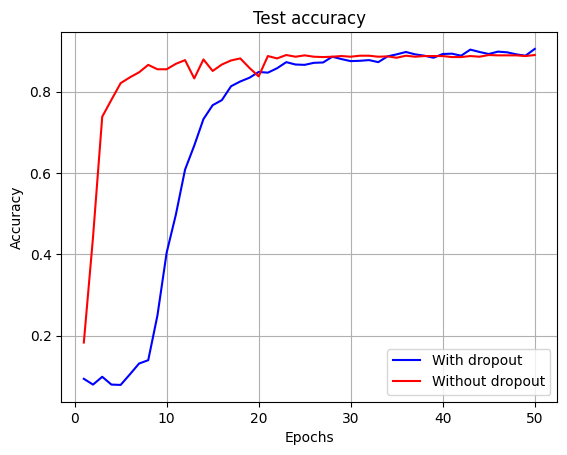

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

# Extract validation accuracy from history object
val_acc = history.history['val_accuracy']
val_acc_raw = history_raw.history['val_accuracy']

# Plot validation accuracy for both models
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, val_acc, 'b', label='With dropout')
plt.plot(epochs, val_acc_raw, 'r', label='Without dropout')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

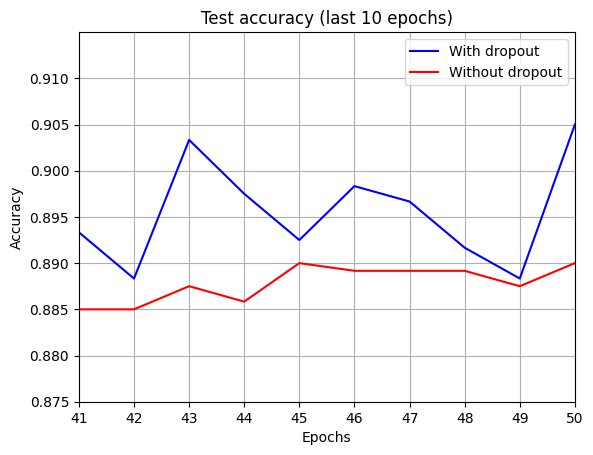

In [71]:
# Zoomed-in plot of last 10 epochs
plt.figure()
plt.plot(epochs[-10:], val_acc[-10:], 'b', label='With dropout')
plt.plot(epochs[-10:], val_acc_raw[-10:], 'r', label='Without dropout')
plt.title('Test accuracy (last 10 epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(epochs[-10], epochs[-1])

# Set y-axis limits to show difference of about 2%
min_y = min(min(val_acc[-10:]), min(val_acc_raw[-10:])) - 0.01
max_y = max(max(val_acc[-10:]), max(val_acc_raw[-10:])) + 0.01
plt.ylim(min_y, max_y)
plt.grid()

plt.show()

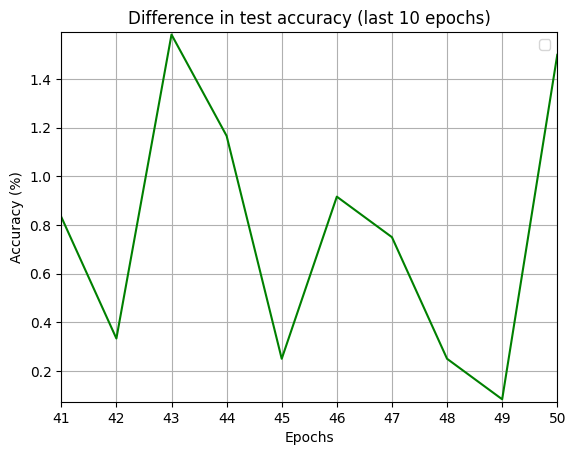

In [78]:
# Zoomed-in plot of last 10 epochs
plt.figure()
diff = 100 * (np.array(val_acc[-10:]) - np.array(val_acc_raw[-10:]))
plt.plot(epochs[-10:], diff, 'g')
plt.title('Difference in test accuracy (last 10 epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.xlim(epochs[-10], epochs[-1])

# Set y-axis limits to show difference of about 2%
min_y = min(diff) - 0.01
max_y = max(diff) + 0.01
plt.ylim(min_y, max_y)
plt.grid()
plt.show()

# Plotting differences in overfitting

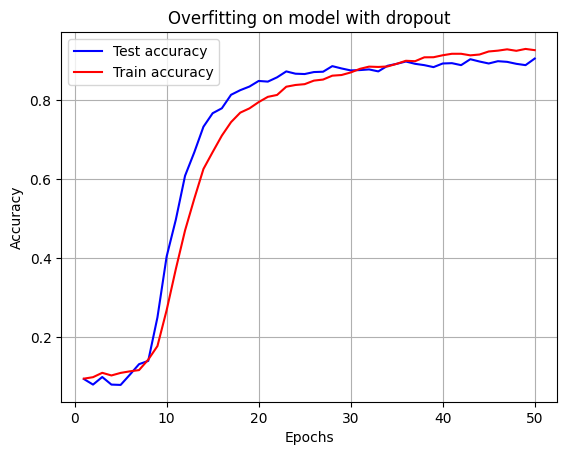

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

# Extract validation accuracy from history object
val_acc = history.history['val_accuracy']
acc = history.history['accuracy']

# Plot validation accuracy for both models
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, val_acc, 'b', label='Test accuracy')
plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.title('Overfitting on model with dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

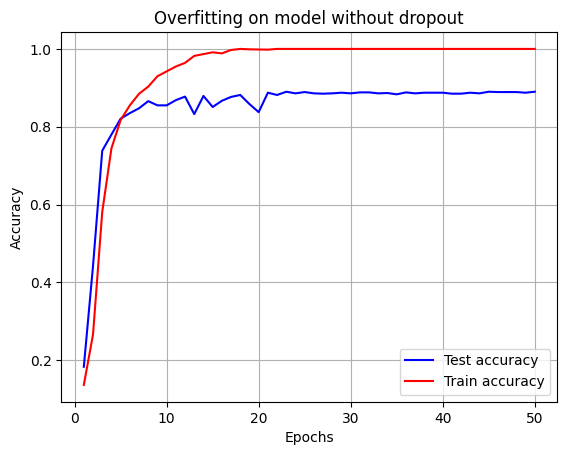

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

# Extract validation accuracy from history object
val_acc = history_raw.history['val_accuracy']
acc = history_raw.history['accuracy']

# Plot validation accuracy for both models
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, val_acc, 'b', label='Test accuracy')
plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.title('Overfitting on model without dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

Dropout slows learning a little bit but solves the overfitting problem and ends up performing about 2% better on the test set, which is what we would expect from the paper's claims.

# Evaluating difference in final test performance

In [58]:
test_loss_raw, test_accuracy_raw = modelraw.evaluate(test_norm, test_labels_categorical, batch_size=4)
print("Test loss:", test_loss_raw)
print("Test accuracy:", test_accuracy_raw)

6508/6508 [==============================] - 22s 3ms/step - loss: 0.8925 - accuracy: 0.8587
Test loss: 0.8925209045410156
Test accuracy: 0.858712375164032


In [57]:
test_loss, test_accuracy = model.evaluate(test_norm, test_labels_categorical, batch_size=4)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

6508/6508 [==============================] - 23s 3ms/step - loss: 0.4428 - accuracy: 0.8796
Test loss: 0.4427981674671173
Test accuracy: 0.8796097040176392


In [61]:
(test_accuracy - test_accuracy_raw) * 100

2.0897328853607178